***Elias Firisa***

***20220773***

*HW#3 Submission*

# Homework 2 on Logistic Regression

This implementation of the logistic regression is the same as what you have leraned in the class. Therefore, it is important that you become familiar with every single line of the codes and know its meaning.

However, this code does not use any basis function and does not use the Hessian matrix but a fixed learning ratio in the gradient descent method to train.

Task 1. Know the meaning of this implementation in the line-by-line manner.

Task 2. Enhance in a whatever way you want, e.g., implementing a basis function, implementing another optimizer instead of the gradient descent.

Submit a report for Task 2 only. Describe how you updated the codes and its decision boundary visualization (see the Plotting the decision boundary section). If you applied a basis function, draw the decision boundary in the space spanned by the bases.

# **Homework 3: Neural Network**

we finished the logistic regression in HW2. You need to extend the source code of HW2 toward deep neural network. Please implement the following items.

Your neural network should be the same as the network in our lecture slides, i.e., three hidden neurons in conjunction with two input neurons and one output neurons. Please use ReLU for the non-linear activation of the hidden neurons. For the output layer, of course, we can use the sigmoid activation since it is a binary classification task. Except the intermediate hidden layer, everything is the same as the logistic regression.

Therefore, you can consider that you also train a basis function with the three hidden neurons. Implement the backpropagation algorithm and basically your implementation should be trainable and its training accuracy must be no smaller than the default logistic regression (I remember that the default HW2 source code shows 7 training errors in its default setting). Recall that I taught that you can use the sub-derivative of ReLU to define the chain rule of the gradient.

For the initialization, you can use any method that you want to make the training process stable. I taught three initialization methods, i.e., Le Cun, Xavier, and He initialization methods. Choose one of them.

For the optimization algorithm, you will change the default gradient descent to other momentum-based one. Please implement Adam.

For the training outcome visualization, please visualize i) the training loss curve whose X-axis means the iteration number and Y-axis means the loss, ii) and the non-linear class boundary your model learned. Refer the following link to know how to visualize class boundaries. This link is just an example. You can use any method to visualize.

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html

### Load the Data and Libraries

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use("ggplot")
%matplotlib inline

from sklearn.inspection import DecisionBoundaryDisplay

In [51]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [52]:
import pandas as pd
import io
# from google.colab import files
# import from drive
from google.colab import drive
drive.mount('/content/drive')

# uploaded = files.upload()
# data=pd.read_csv("data.csv",index_col="t")
# data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# file path should be changed if this code is running on other device
data=pd.read_csv('/content/drive/MyDrive/spring2025/Machine Learning/data.csv',index_col='t') # TAs should change this to the path of the data on their machine, should they wanna run it
data.head()

x1         x2
t                      
0  34.623660  78.024693
0  30.286711  43.894998
0  35.847409  72.902198
1  60.182599  86.308552
1  79.032736  75.344376

In [70]:
data.shape


(100, 2)

In [71]:
feature = data[["x1", "x2"]].values
class_label = data.index.values
feature[0:5]

array([[34.62365962, 78.02469282],
       [30.28671077, 43.89499752],
       [35.84740877, 72.90219803],
       [60.18259939, 86.3085521 ],
       [79.03273605, 75.34437644]])

### Visualize the  Raw Data

In [56]:
# class_label.shape
# class0=class_label==1

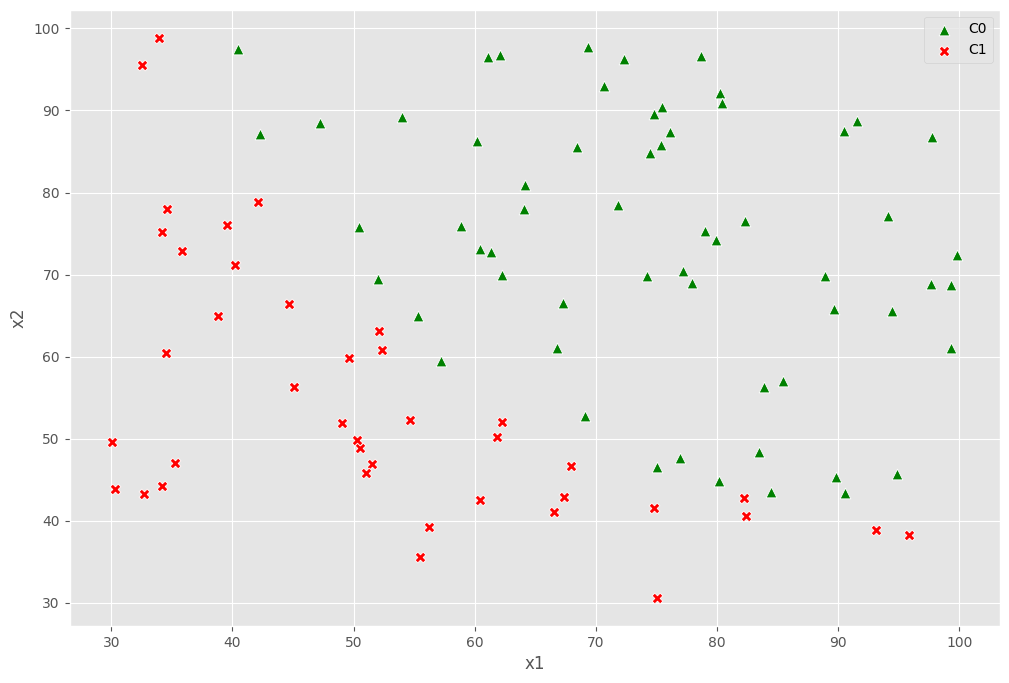

In [72]:
class_c0 = (class_label ==1).reshape(100, 1)
class_c1 = (class_label == 0).reshape(100, 1)

ax = sns.scatterplot(x = feature[class_c0[:, 0], 0],
                     y = feature[class_c0[:, 0], 1],
                     marker = "^",
                     color = "green",
                     s = 60)
sns.scatterplot(x = feature[class_c1[:, 0], 0],
                y = feature[class_c1[:, 0], 1],
                marker = "X",
                color = "red",
                s = 60)

ax.set(xlabel="x1", ylabel="x2")
ax.legend(["C0", "C1"])
plt.show();

In [74]:
X = data[['x1','x2']].values  # shape (N,2)
y = data.index.values.reshape(-1,1)  # shape (N,1)

# Standardize features
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

#1 Architecture:
 Input layer (2 neurons)
Hidden layer (3 neurons with ReLU activation)
Output layer (1 neuron with sigmoid activation)

Input Layer (2 neurons): x1, x2
   |
   V
Hidden Layer (3 neurons): h1, h2, h3
   |
   V
Output Layer (1 neuron): y_pred

In [75]:

#  bias terms will be added to the  inputs
# We will handle bias inside layers, so no explicit bias column here.

# One hidden layer ( of 3 neurons) neural network: 2->3->1
'''as extension of logistic regression which had only input and output layers, our neural network
has a hidden layer in between the two making the function highly nonlinear to learn nonlinear decision boundary
'''
class NeuralNet:
    def __init__(self, input_dim=2, hidden_dim=3, output_dim=1, init_method='he'):
        # initializing weights and biases
        self.init_method = init_method
        self.W1 = self.init_weights(input_dim, hidden_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = self.init_weights(hidden_dim, output_dim)
        self.b2 = np.zeros((1, output_dim))

        # Adam optimizer state: momentum and velocity
        self.mW1, self.vW1 = np.zeros_like(self.W1), np.zeros_like(self.W1)
        self.mb1, self.vb1 = np.zeros_like(self.b1), np.zeros_like(self.b1)
        self.mW2, self.vW2 = np.zeros_like(self.W2), np.zeros_like(self.W2)
        self.mb2, self.vb2 = np.zeros_like(self.b2), np.zeros_like(self.b2)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1e-8
        self.t = 0

    def init_weights(self, fan_in, fan_out):
        # He initialization for ReLU
        if self.init_method == 'he':
            std = np.sqrt(2. / fan_in)
        elif self.init_method == 'xavier':
            std = np.sqrt(1. / fan_in)
        else:
            std = 0.01
        return np.random.randn(fan_in, fan_out) * std

    def relu(self, Z):
        return np.maximum(0, Z)

    def d_relu(self, Z):
        return (Z > 0).astype(float)

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def forward(self, X):
        # hidden layer
        self.Z1 = X @ self.W1 + self.b1  # pre-activation
        self.A1 = self.relu(self.Z1)     # post-activation
        # output layer
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2

    def compute_loss(self, y_pred, y_true):
        # binary cross-entropy
        m = y_true.shape[0]
        loss = -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))
        return loss

    def backward(self, X, y_true):
        m = X.shape[0]
        # output layer gradient
        dZ2 = self.A2 - y_true                 # shape (m,1)
        dW2 = self.A1.T @ dZ2 / m              # (3,1)
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        # hidden layer gradient
        dA1 = dZ2 @ self.W2.T                  # (m,3)
        dZ1 = dA1 * self.d_relu(self.Z1)       # (m,3)
        dW1 = X.T @ dZ1 / m                    # (2,3)
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        return dW1, db1, dW2, db2

    def update_params(self, grads, lr=0.001):
        # Adam update
        dW1, db1, dW2, db2 = grads
        self.t += 1
        # update m ( momentum), v (velocity)
        for param, dparam, m, v in [
            (self.W1, dW1, self.mW1, self.vW1),
            (self.b1, db1, self.mb1, self.vb1),
            (self.W2, dW2, self.mW2, self.vW2),
            (self.b2, db2, self.mb2, self.vb2),
        ]:
            m[:] = self.beta1 * m + (1 - self.beta1) * dparam
            v[:] = self.beta2 * v + (1 - self.beta2) * (dparam ** 2)
            m_hat = m / (1 - self.beta1 ** self.t)
            v_hat = v / (1 - self.beta2 ** self.t)
            param[:] -= lr * m_hat / (np.sqrt(v_hat) + self.eps)



In [76]:
# Training
model = NeuralNet(init_method='he') # intializing with 'He/Kaiming' initialization
num_iters = 5000
learning_rate = 0.01
loss_history = []
for i in range(1, num_iters+1):
    # forward
    y_pred = model.forward(X)
    loss = model.compute_loss(y_pred, y)
    loss_history.append(loss)
    # backward
    grads = model.backward(X, y)
    # update
    model.update_params(grads, lr=learning_rate)
    if i % 500 == 0:
        print(f"Iter {i}, loss = {loss:.4f}")



Iter 500, loss = 0.0890
Iter 1000, loss = 0.0327
Iter 1500, loss = 0.0146
Iter 2000, loss = 0.0076
Iter 2500, loss = 0.0043
Iter 3000, loss = 0.0026
Iter 3500, loss = 0.0016
Iter 4000, loss = 0.0011
Iter 4500, loss = 0.0007
Iter 5000, loss = 0.0005


In [77]:
# Training accuracy
y_pred_label = (model.forward(X) > 0.5).astype(int)
train_acc = np.mean(y_pred_label == y)
print(f"Training accuracy: {train_acc*100:.2f}%")



Training accuracy: 100.00%


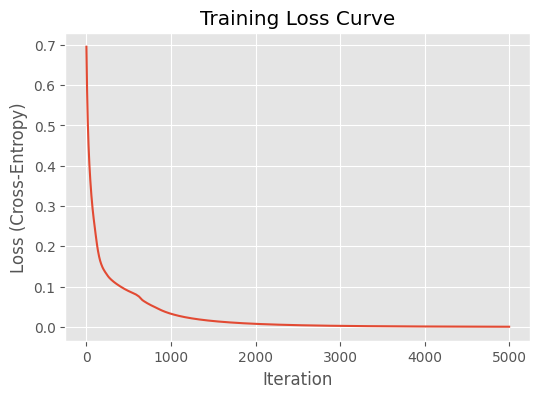

In [78]:
# Plot loss curve
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss (Cross-Entropy)')
plt.title('Training Loss Curve')
plt.show()



<ipython-input-75-d3fe926e531c>:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.Z1 = X @ self.W1 + self.b1  # pre-activation
<ipython-input-75-d3fe926e531c>:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.maximum(0, Z)
<ipython-input-75-d3fe926e531c>:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.Z2 = self.A1 @ self.W2 + self.b2
<ipython-input-75-d3fe926e531c>:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1 / (1 + np.exp(-Z))


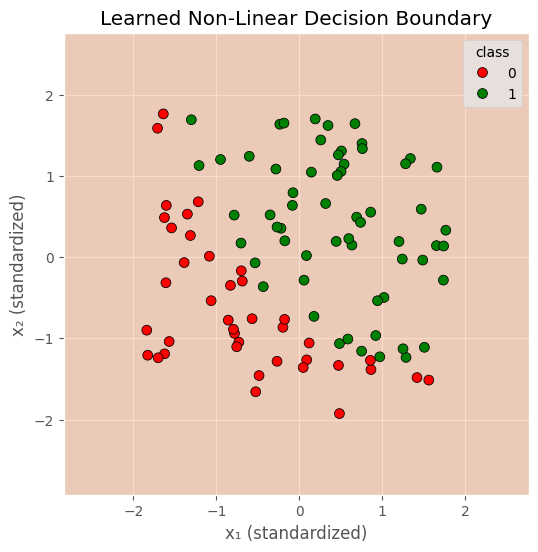

In [84]:
import torch

x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 300),
    np.linspace(x2_min, x2_max, 300),
)

#  stack into shape (n_points,2) then standardize
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid_std = (grid * std) + mean   #

#  run through the model
with torch.no_grad():
    inputs = torch.tensor(grid_std, dtype=torch.float32)

    probs  = model.forward(inputs).numpy().reshape(-1)  # shape (n_points,)
    preds  = (probs > 0.5).astype(int)

#  reshape back into the mesh
Z = preds.reshape(xx1.shape)

# plot decision boundary via contourf
plt.figure(figsize=(6,6))
plt.contourf(xx1, xx2, Z, alpha=0.3, cmap="RdYlGn")

# overlay the training points
# Flattening the y array to make it 1-dimensional
sns.scatterplot(x=X[:,0], y=X[:,1],
                hue=y.flatten(), palette=["red","green"],
                edgecolor="k", s=50)

plt.xlabel("x₁ (standardized)")
plt.ylabel("x₂ (standardized)")
plt.title("Learned Non-Linear Decision Boundary")
plt.legend(title="class")

plt.show()